In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [4]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [4]:
X_train=np.concatenate([dt.training_images,dt.test_images]).reshape(-1,32,32,3)*2-1

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 930
Seed: 861


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128*8*8,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,128)))
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(upsampling())
#     model.add(dropout(0.25))
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(dropout(0.2))
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 8192)               leakyRelu        827392
__________________________________________________________________________________________
2 reshape(reshape)        (None, 8, 8, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 16, 16, 128)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 64)         leakyRelu        73792
__________________________________________________________________________________________
5 Batch

In [95]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(32,32,3)))
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.25))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 16, 16, 32)         leakyRelu        896
__________________________________________________________________________________________
2 dropout(dropout)        (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
3 conv2d(conv2d)          (None, 8, 8, 64)           leakyRelu        18496
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 8, 8, 64)           echo             256
__________________________________________________________________________________________
5 dropou

In [8]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [9]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [10]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%50:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 2


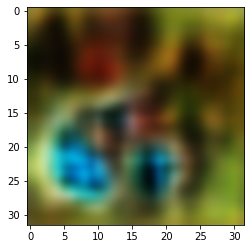

[0.41898373]
Progress: 5.23 %     Dloss: 24.425189971923828    err: 0.01737266220152378     Sample time: 1.344s    __

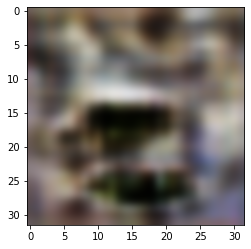

[0.05327379]
Progress: 10.56 %     Dloss: 28.392475128173828    err: 0.015954313799738884     Sample time: 1.320s    _

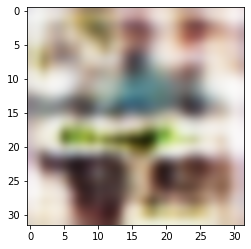

[0.08631673]
Progress: 15.89 %     Dloss: 31.000150680541992    err: 0.014280510134994984     Sample time: 1.728s    _

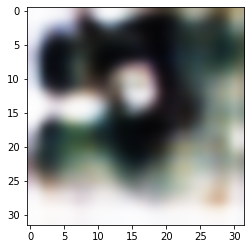

[0.25965607]
Progress: 21.23 %     Dloss: 36.15262985229492    err: 0.016909560188651085     Sample time: 1.331s    __

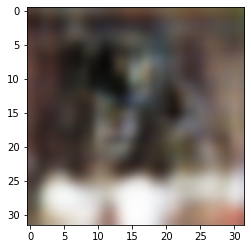

[0.23536652]
Progress: 26.56 %     Dloss: 32.29203796386719    err: 0.016731761395931244     Sample time: 1.351s    __

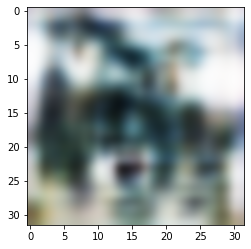

[0.00641413]
Progress: 31.89 %     Dloss: 29.74791717529297    err: 0.014923524111509323     Sample time: 1.340s    __

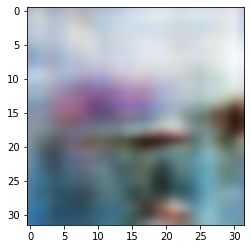

[0.40205544]
Progress: 37.23 %     Dloss: 29.7115478515625    err: 0.018504880368709564     Sample time: 1.486s    ___

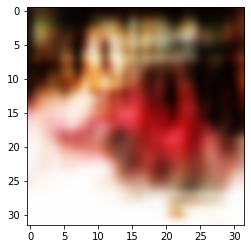

[0.00664494]
Progress: 42.56 %     Dloss: 27.60771942138672    err: 0.01576162688434124     Sample time: 1.173s    _ _

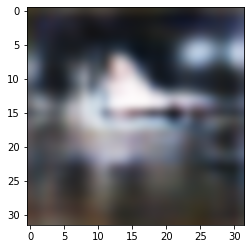

[0.8565828]
Progress: 47.89 %     Dloss: 22.833885192871094    err: 0.016536399722099304     Sample time: 1.328s    _

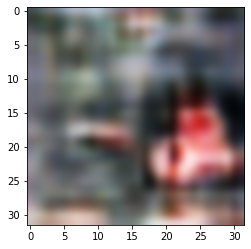

[0.01967386]
Progress: 48.75 %     Dloss: 32.95512390136719    err: 0.016069157049059868     Sample time: 3.643s    __

KeyboardInterrupt: 

In [64]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

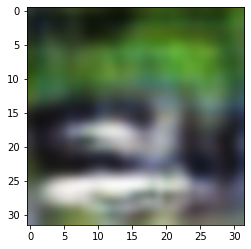

[0.66649705]


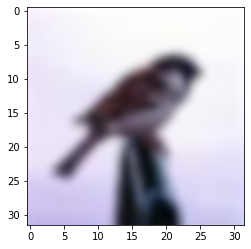

[[0.98338115]]


In [92]:
noise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

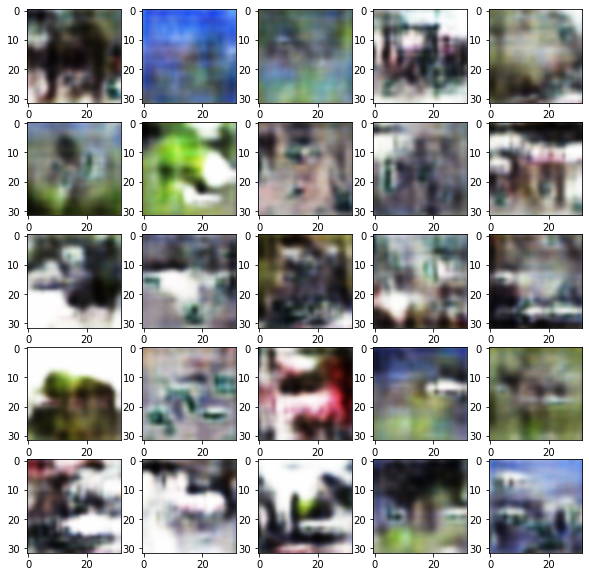

In [94]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')